In [1]:
import pandas as pd
import joblib
import shap
from sklearn.model_selection import train_test_split

# Load the Random Forest model from the file
loaded_rf_model = joblib.load('random_forest_model.joblib')
display(loaded_rf_model)

RandomForestRegressor(random_state=42)

In [2]:
# Reading Data
df = pd.read_csv("sales_predictions.csv")
df

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976


In [3]:
# Fixing inconsistencies in categorical data
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'LF': 'Low Fat', 'low fat': 'Low Fat', 'reg': 'Regular'})
df = df.drop_duplicates()

# Features [X] & Target [y]
X = df.drop(['Item_Outlet_Sales'], axis=1)
y = df['Item_Outlet_Sales']

In [4]:
# One-hot encode categorical features
X = pd.get_dummies(X)

# Split your data into train and test sets (if not already done in Part 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
# Create a sample of your training data for SHAP explanation
X_shap = shap.sample(X_train, 100)
y_shap = y_train[:100]  # Corresponding target values for the samples

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.


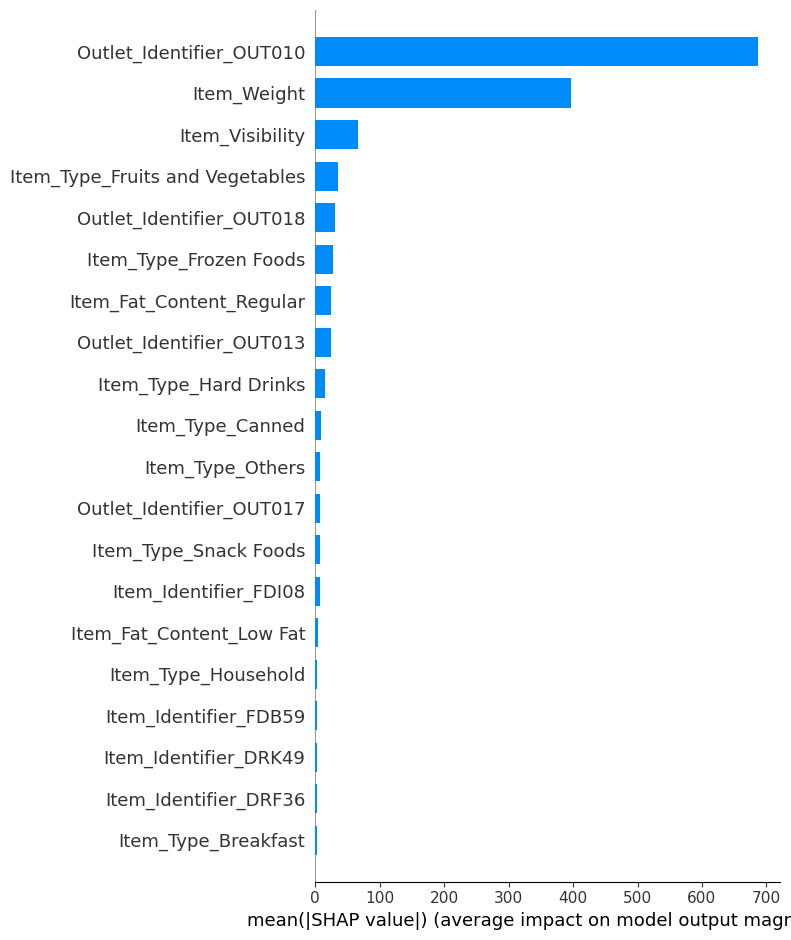

In [6]:
# Create a model explainer
explainer = shap.Explainer(loaded_rf_model, X_shap)

# Calculate the shap values for your model
shap_values = explainer(X_shap)

# Create a summary plot - with plot_type='bar'
shap.summary_plot(shap_values, X_shap, plot_type='bar')

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


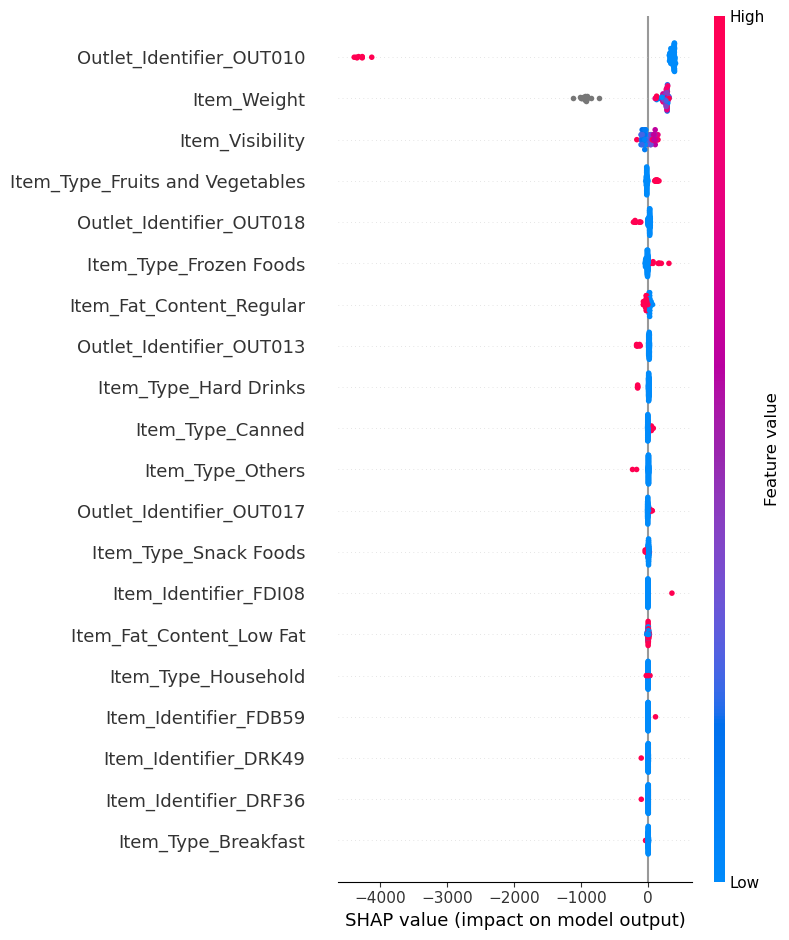

In [7]:
shap.summary_plot(shap_values, X_shap, plot_type='dot')

- **In the SHAP summary plot, the length of the bars shows how much each feature impacts the predictions of the model. Longer bars mean that the feature has a bigger effect on the predictions, while shorter bars mean it has a smaller effect.**

- For example, in your SHAP summary plot, the features "Outlet_Identifier_OUT010" and "Item_Weight" have longer bars, which means they have a stronger influence on the model's predictions. This means that changes in these features can lead to bigger changes in the predicted sales. On the other hand, the feature "Item_Type_Breakfast" has a shorter bar, which means it has a weaker influence on the predictions. Changes in this feature have a smaller impact on the predicted sales.

- **SHAP values give us more detailed insights into how each feature affects the model's predictions for individual data points. Positive SHAP values mean that a feature increases the model's prediction, while negative SHAP values mean it decreases the prediction. This information helps us understand the importance and direction of each feature's impact on the model's predictions.**

- Overall, SHAP values and the SHAP summary plot provide valuable information about the relationships between features and the target variable in the context of the model, helping us better understand how the model makes its predictions.

# Local Explanations

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
import shap
import lime
import lime.lime_tabular

# Reading Data
df = pd.read_csv("sales_predictions.csv")
# Fixing inconsistencies in categorical data
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'LF': 'Low Fat', 'low fat': 'Low Fat', 'reg': 'Regular'})
df = df.drop_duplicates()

In [ ]:
# Features [X] & Target [y]
drop_feats = ['Item_Identifier', 'Item_Outlet_Sales']  # Adjust the feature names
y = df['Item_Outlet_Sales'].copy()
X = df.drop(columns=['Item_Outlet_Sales', *drop_feats]).copy()

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Preprocessing Pipeline
num_features = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']
cat_features = ['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())])
cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('num', num_pipeline, num_features), ('cat', cat_pipeline, cat_features)])

In [ ]:
# Fit the data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [ ]:
# Tree-Based Model - Random Forest Regressor
rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train_preprocessed, y_train)

In [ ]:
# Load the model explainer
explainer = shap.Explainer(rf_reg, X_test_preprocessed)

In [ ]:
# Reset the indices of X_test_preprocessed
X_test_preprocessed_reset = pd.DataFrame(X_test_preprocessed, columns=num_features + list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(input_features=cat_features)))
X_test_preprocessed_reset.index = X_test.index  # Resetting indices to match X_test

In [ ]:
# Select example rows with low and high sales
low_sales_index = y_test.idxmin()
high_sales_index = y_test.idxmax()
low_sales_example = X_test_preprocessed_reset.loc[[low_sales_index]]
high_sales_example = X_test_preprocessed_reset.loc[[high_sales_index]]

In [ ]:
# Initialize the LIME explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_train_preprocessed, mode="regression")
# Explain the example with low sales using LIME
low_sales_lime_exp = lime_explainer.explain_instance(low_sales_example.values[0], rf_reg.predict)
# Explain the example with high sales using LIME
high_sales_lime_exp = lime_explainer.explain_instance(high_sales_example.values[0], rf_reg.predict)

In [ ]:
# Save Lime explanation plots as screenshots
low_sales_lime_exp.save_to_file("low_sales_lime_explanation.png")
high_sales_lime_exp.save_to_file("high_sales_lime_explanation.png")
print("Low sales index:", low_sales_index)
print("High sales index:", high_sales_index)

In [ ]:
# Generate individual SHAP force plots for the examples
shap.initjs()

low_sales_shap_values = explainer.shap_values(X_test_preprocessed_reset.loc[[low_sales_index]])
shap.force_plot(explainer.expected_value, low_sales_shap_values, X_test_preprocessed_reset.loc[[low_sales_index]], show=False)
plt.savefig("low_sales_shap_force_plot.png")  # Save the plot as PNG
plt.clf()  # Clear the plot

high_sales_shap_values = explainer.shap_values(X_test_preprocessed_reset.loc[[high_sales_index]])
shap.force_plot(explainer.expected_value, high_sales_shap_values, X_test_preprocessed_reset.loc[[high_sales_index]], show=False)
plt.savefig("high_sales_shap_force_plot.png")  # Save the plot as PNG
plt.clf()  # Clear the plot